In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from ALLCools.plot.color import plot_colorbar, plot_color_legend
import anndata
from cemba_data.tools.integration.utilities import calculate_direct_confusion

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

## Load Data

### Cell tidy data

In [3]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
brain_region_df = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/BrainRegion.txt',
    sep='\t',
    index_col='RegionName')

region_name_order = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/order/DissectionRegionOrder.txt',
                           index_col=0, header=None).index
dissection_region_order = brain_region_df.loc[region_name_order]['DissectionRegion'].tolist()

In [5]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'

### PC

In [6]:
adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/study/Level1-CellClass/ALL_manual/Coords/adata.with_pc_and_coords.h5ad'
)

## Replicate median PC

In [7]:
pc_df = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names)

replicate_pc_df = pc_df.groupby(cell_tidy_data['Replicate']).median()

In [8]:
between_rep_corr = replicate_pc_df.T.corr()
order = np.argsort(between_rep_corr.index.map(lambda i: dissection_region_order.index(i.split('-')[0])))
between_rep_corr = between_rep_corr.iloc[order, order].copy()

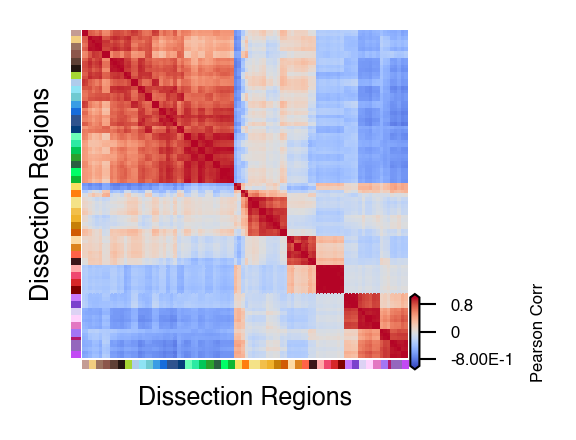

In [9]:
fig = plt.figure(figsize=(1.5, 1.5), dpi=300)

gs = fig.add_gridspec(31, 32)

ax = fig.add_subplot(gs[:-1, 1:-1])
ax_row = fig.add_subplot(gs[-1, 1:-1])
ax_col = fig.add_subplot(gs[:-1, 0])
cax = fig.add_subplot(gs[-7:, -1])

sns.heatmap(ax=ax,
            data=between_rep_corr,
            cbar=False,
            vmin=-1,
            vmax=1,
            cmap='coolwarm')
ax.set(xticks=[], yticks=[], ylabel='', xlabel='')

plot_color_legend(region_palette,
                  ax=ax_row,
                  order=between_rep_corr.index.map(lambda i: i.split('-')[0]))
plot_color_legend(region_palette,
                  ax=ax_col,
                  order=between_rep_corr.index.map(lambda i: i.split('-')[0]),
                  transpose=True)
ax_row.set(xticks=[], yticks=[], xlabel='Dissection Regions')
ax_col.set(xticks=[], yticks=[], ylabel='Dissection Regions')
sns.despine(ax=ax_row, left=True, bottom=True)
sns.despine(ax=ax_col, left=True, bottom=True)

plot_colorbar(cax=cax, cmap='coolwarm', hue_norm=(-1, 1), label='Pearson Corr')
fig.savefig(f'PC.Corr.heatmap.pdf')

In [11]:
between_rep = []
within_rep = []
for (a, b), score in between_rep_corr.stack().iteritems():
    if a == b:
        continue
    elif a[:-7] == b[:-7]:
        within_rep.append(score)
    else:
        between_rep.append(score)

data1 = pd.DataFrame([between_rep], index=['Pearson Corr.']).T
data1['Type'] = 'Between\nRegion'
data2 = pd.DataFrame([within_rep], index=['Pearson Corr.']).T
data2['Type'] = 'Between\nRep.'
data = pd.concat([data1, data2])


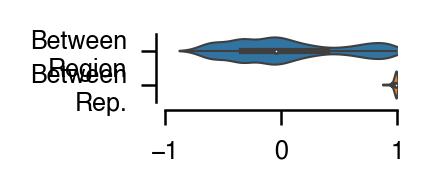

In [16]:
fig, ax = plt.subplots(figsize=(1, 0.3), dpi=300)
sns.violinplot(x='Pearson Corr.',
               y='Type',
               data=data,
               cut=1,
               scale='width',
               orient='h', linewidth=0.5)
ax.set(xlabel='', xlim=(-1, 1), ylabel='')
sns.despine(fig=fig, offset=2)
fig.savefig(f'PC.Corr.dist.pdf', bbox_inches='tight')